# ChemTab (PCDNN_V2) Benchmark Notebook
### This notebook contains experiments around the different parameters for the model
#### Amol Salunkhe

Develop a deep neural architecture ChemTab that jointly optimizes two neural networks for the tasks of reduced basis learning (encoder) and reverse lookup function learning (regressor). The first network (Shallow AutoEncoder) will focus on linear dimensionality reduction and create a linear embedding for the source species. The second network (Deep Regressor) will focus on learning a lookup function from the linear embedding to the Thermo-chemical state variables.

### Overall Problem Formulation

\begin{equation}\label{eqn:lossfunc}
    \begin{aligned}
    \textrm{min} \quad \mathcal{L}_{joint} = \lambda_{encoder} * \mathcal{L}_{encoder} + \lambda_{regressor}* \mathcal{L}_{regressor} 
    \end{aligned}
\end{equation}

### Reduced Basis Problem Formulation (Encoder)

\begin{equation}\label{eqn:Reduced-Basis-Learning}
    \begin{aligned}
    \def\sss{\scriptscriptstyle}
    {}
    \def\stacktype{L}
        {\mathrm{Y^{'}}}{\sss n\times k} =  {Y}{\sss n\times s} \times {W}{\sss s\times k} \\
        \textrm{s.t.,} \quad k \ll s\\
        \mathrm{\phi}(Y) \approx \mathrm{\phi}(Y^{'})\\
        \textrm{where, W is the Reduced Basis / encoder} \\
        \mathrm{\phi} \quad \textrm{is the Reverse Lookup function / regressor}
    \end{aligned}
\end{equation}


### Lookup Learning Problem Formulation (Regressor)

\begin{equation}\label{eqn:Reverse-Lookup-Learning}
    \begin{aligned}
        \textrm{min} \quad ||{S_i} - \mathrm{\phi}(Y^{'}_i)||_{p}\\
        \textrm{s.t.,} \quad p \in r \\
        \quad k \ll s\\
        \mathrm{\phi}(Y) \approx \mathrm{\phi}(Y^{'})\\
    \end{aligned}
\end{equation}




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression
from sklearn import gaussian_process
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize
from sklearn.utils.optimize import _check_optimize_result
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
import time
from sklearn.decomposition import PCA, SparsePCA
%matplotlib inline
import seaborn as sns
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.keras.constraints import UnitNorm, Constraint
import sys

## Helpers

In [2]:
from benchmark_model_code import * # Network Helpers
from benchmark_data_code import * # Data Helpers

import random
import numpy as np
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)
halfData = getHalfData()

#error_df = pd.DataFrame(columns=['TotalAbsoluteError','TotalSquaredError','MeanAbsoluteError','MeanSquaredError','MeanPercentageError','NumPoints'])

/home/dwyerdei/rom_project2/src/benchmark_data_code.py:267: UserWarning: transparently scaling Zmix!
  warnings.warn('transparently scaling Zmix!')


### Constrained DNN -- Baseline (Zmix + 4 Dim Linear Embedding; All Constraints)

In [3]:
encoding_dim = 4

species_inputs = keras.Input(shape=(53,), name="species_input")

Zmix = keras.Input(shape=(1,), name="Zmix")

x = layers.Dense(encoding_dim, activation="linear",kernel_constraint=UnitNorm(axis=0),kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0),activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.))(species_inputs)

#Concatenate the Linear Embedding and Zmix together
x = layers.Concatenate()([Zmix, x])

x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
#Predict the source energy
souener_pred = layers.Dense(1, name="prediction")(x)

model = keras.Model(
    inputs=[species_inputs,Zmix],
    outputs=[souener_pred],
)


#,kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0)
#,kernel_constraint=UnitNorm(axis=0)
#,activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 species_input (InputLayer)     [(None, 53)]         0           []                               
                                                                                                  
 Zmix (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 4)            216         ['species_input[0][0]']          
                                                                                                  
 concatenate (Concatenate)      (None, 5)            0           ['Zmix[0][0]',                   
                                                                  'dense[0][0]']              

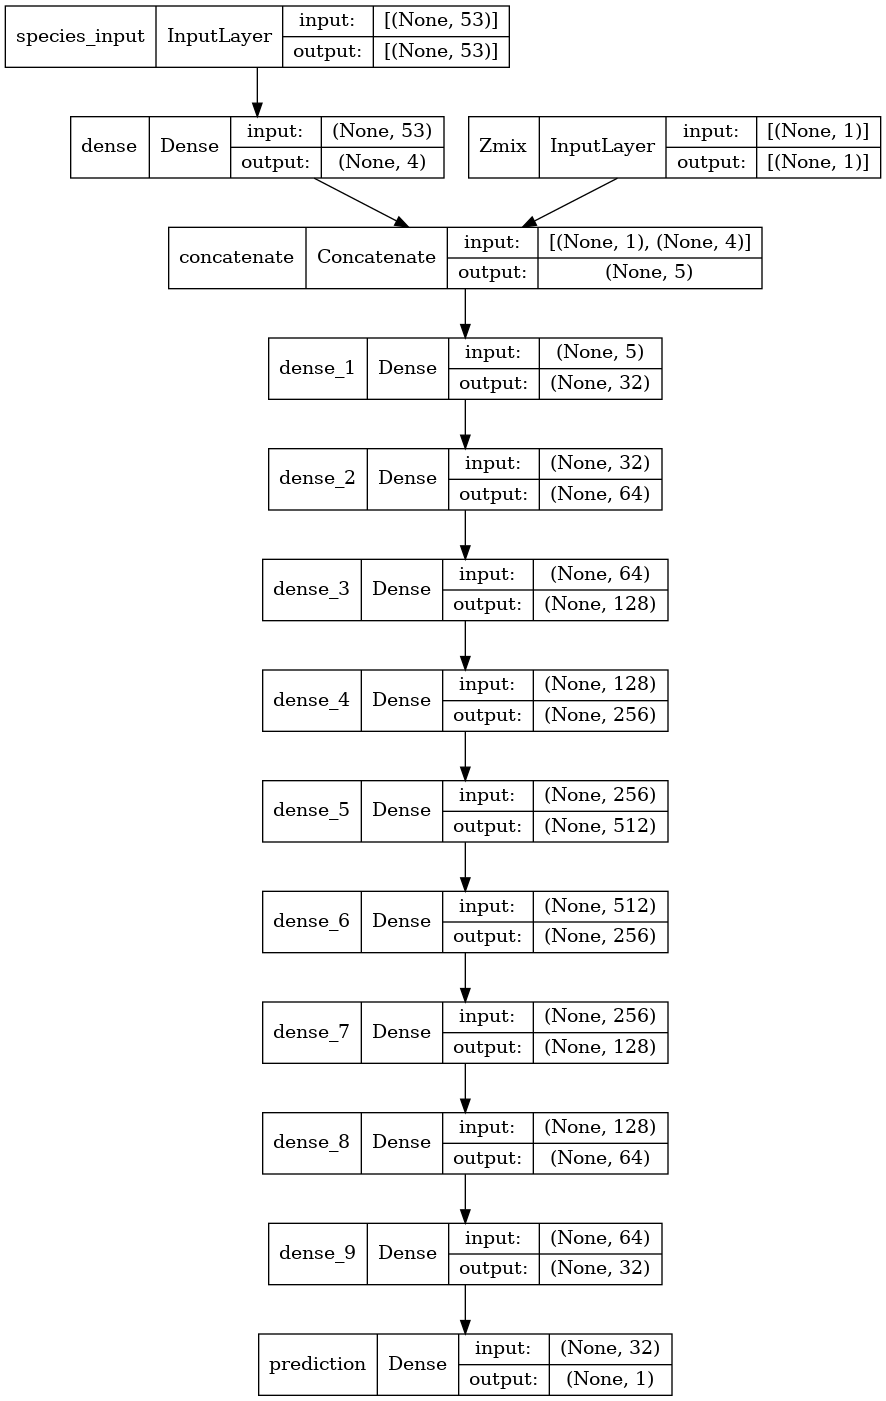

In [6]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96)

In [7]:
model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))

## Loading of Base Code Model:

In [8]:
import pickle
with open('base_code_model/custom_objects.pickle', 'rb') as f:
    custom_objects = pickle.load(f)

def get_metrics():
    def log_mse(x,y): return tf.math.log(tf.math.reduce_mean((x-y)**2))
    def log_mae(x,y): return tf.math.log(tf.math.reduce_mean(tf.math.abs(x-y)))
    def exp_mse_mag(x,y): return tf.math.log(tf.math.reduce_mean((tf.math.exp(x)-tf.math.exp(y))**2))/tf.math.log(10.0)
    def exp_mae_mag(x,y): return tf.math.log(tf.math.reduce_mean(tf.math.abs(tf.math.exp(x)-tf.math.exp(y))))/tf.math.log(10.0)
    def R2(yt,yp): return 1-tf.math.reduce_mean((yp-yt)**2)/(tf.math.reduce_std(yt)**2)
    def exp_R2(yt,yp): # these are actual names above is for convenience
        return R2(tf.math.exp(yt), tf.math.exp(yp))
    return locals()
metrics = get_metrics()
custom_objects.update(metrics)

model = keras.models.load_model('base_code_model/base_code_model.h5', custom_objects = custom_objects)

In [9]:
model.summary(expand_nested=True)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 species_input (InputLayer)     [(None, 53)]         0           []                               
                                                                                                  
 zmix (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 linear_embedding (Functional)  (None, 4)            216         ['species_input[0][0]']          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| species_input (InputLayer)   [(None, 53)]         0           []                               |
|                                                                                           

Epoch 1/100
206/206 [==============================] - 3s 12ms/step - loss: 0.0630 - mae: 0.0321 - mse: 0.0071 - log_mse: -5.6587 - log_mae: -3.5800 - exp_mse_mag: -2.1199 - exp_mae_mag: -1.4359 - exp_R2: 0.5882 - R2: 0.6547 - val_loss: 0.0247 - val_mae: 0.0230 - val_mse: 0.0042 - val_log_mse: -6.1228 - val_log_mae: -3.8880 - val_exp_mse_mag: -2.3633 - val_exp_mae_mag: -1.5800 - val_exp_R2: 0.6853 - val_R2: 0.7217
Epoch 2/100
206/206 [==============================] - 2s 10ms/step - loss: 0.0230 - mae: 0.0198 - mse: 0.0022 - log_mse: -6.6198 - log_mae: -4.0000 - exp_mse_mag: -2.5297 - exp_mae_mag: -1.6182 - exp_R2: 0.8281 - R2: 0.8672 - val_loss: 0.0176 - val_mae: 0.0150 - val_mse: 0.0012 - val_log_mse: -7.2400 - val_log_mae: -4.2972 - val_exp_mse_mag: -2.8661 - val_exp_mae_mag: -1.7653 - val_exp_R2: 0.8604 - val_R2: 0.8750
Epoch 3/100
206/206 [==============================] - 2s 10ms/step - loss: 0.0207 - mae: 0.0165 - mse: 0.0014 - log_mse: -7.1105 - log_mae: -4.1752 - exp_mse_mag: 

206/206 [==============================] - 2s 10ms/step - loss: 0.0081 - mae: 0.0058 - mse: 1.8841e-04 - log_mse: -9.1142 - log_mae: -5.2182 - exp_mse_mag: -3.6464 - exp_mae_mag: -2.1560 - exp_R2: 0.9793 - R2: 0.9828 - val_loss: 0.0092 - val_mae: 0.0061 - val_mse: 2.6403e-04 - val_log_mse: -8.9740 - val_log_mae: -5.1928 - val_exp_mse_mag: -3.5955 - val_exp_mae_mag: -2.1501 - val_exp_R2: 0.9623 - val_R2: 0.9673
Epoch 21/100
206/206 [==============================] - 2s 10ms/step - loss: 0.0087 - mae: 0.0064 - mse: 2.2995e-04 - log_mse: -8.8798 - log_mae: -5.1271 - exp_mse_mag: -3.5123 - exp_mae_mag: -2.1070 - exp_R2: 0.9767 - R2: 0.9814 - val_loss: 0.0094 - val_mae: 0.0081 - val_mse: 3.8103e-04 - val_log_mse: -8.4078 - val_log_mae: -4.8991 - val_exp_mse_mag: -3.2558 - val_exp_mae_mag: -1.9973 - val_exp_R2: 0.9468 - val_R2: 0.9585
Epoch 22/100
206/206 [==============================] - 2s 10ms/step - loss: 0.0086 - mae: 0.0066 - mse: 2.4711e-04 - log_mse: -8.8635 - log_mae: -5.0968 - exp

206/206 [==============================] - 2s 10ms/step - loss: 0.0065 - mae: 0.0048 - mse: 1.3360e-04 - log_mse: -9.5663 - log_mae: -5.4195 - exp_mse_mag: -3.8310 - exp_mae_mag: -2.2422 - exp_R2: 0.9901 - R2: 0.9914 - val_loss: 0.0057 - val_mae: 0.0041 - val_mse: 1.3116e-04 - val_log_mse: -9.7562 - val_log_mae: -5.6120 - val_exp_mse_mag: -4.0088 - val_exp_mae_mag: -2.3487 - val_exp_R2: 0.9776 - val_R2: 0.9795
Epoch 40/100
206/206 [==============================] - 2s 10ms/step - loss: 0.0061 - mae: 0.0044 - mse: 1.2613e-04 - log_mse: -9.5659 - log_mae: -5.4979 - exp_mse_mag: -3.8289 - exp_mae_mag: -2.2726 - exp_R2: 0.9882 - R2: 0.9903 - val_loss: 0.0082 - val_mae: 0.0051 - val_mse: 2.7625e-04 - val_log_mse: -9.2451 - val_log_mae: -5.4262 - val_exp_mse_mag: -3.7753 - val_exp_mae_mag: -2.2671 - val_exp_R2: 0.9623 - val_R2: 0.9650
Epoch 41/100
206/206 [==============================] - 2s 11ms/step - loss: 0.0075 - mae: 0.0047 - mse: 1.4823e-04 - log_mse: -9.4918 - log_mae: -5.4500 - exp

206/206 [==============================] - 2s 11ms/step - loss: 0.0073 - mae: 0.0052 - mse: 1.5188e-04 - log_mse: -9.4411 - log_mae: -5.3624 - exp_mse_mag: -3.7698 - exp_mae_mag: -2.2142 - exp_R2: 0.9858 - R2: 0.9887 - val_loss: 0.0046 - val_mae: 0.0029 - val_mse: 8.3002e-05 - val_log_mse: -10.3909 - val_log_mae: -5.9727 - val_exp_mse_mag: -4.2442 - val_exp_mae_mag: -2.4956 - val_exp_R2: 0.9865 - val_R2: 0.9880
Epoch 59/100
206/206 [==============================] - 2s 10ms/step - loss: 0.0055 - mae: 0.0038 - mse: 9.4368e-05 - log_mse: -9.9299 - log_mae: -5.6647 - exp_mse_mag: -3.9837 - exp_mae_mag: -2.3454 - exp_R2: 0.9918 - R2: 0.9932 - val_loss: 0.0055 - val_mae: 0.0038 - val_mse: 1.3845e-04 - val_log_mse: -9.8794 - val_log_mae: -5.6892 - val_exp_mse_mag: -3.9575 - val_exp_mae_mag: -2.3544 - val_exp_R2: 0.9776 - val_R2: 0.9804
Epoch 60/100
206/206 [==============================] - 2s 10ms/step - loss: 0.0058 - mae: 0.0041 - mse: 1.1495e-04 - log_mse: -9.8330 - log_mae: -5.6036 - ex

206/206 [==============================] - 2s 11ms/step - loss: 0.0072 - mae: 0.0033 - mse: 6.6771e-05 - log_mse: -10.3021 - log_mae: -5.8029 - exp_mse_mag: -4.1325 - exp_mae_mag: -2.4037 - exp_R2: 0.9948 - R2: 0.9958 - val_loss: 0.0118 - val_mae: 0.0063 - val_mse: 2.2481e-04 - val_log_mse: -8.8926 - val_log_mae: -5.1565 - val_exp_mse_mag: -3.4826 - val_exp_mae_mag: -2.1099 - val_exp_R2: 0.9652 - val_R2: 0.9716
Epoch 78/100
206/206 [==============================] - 2s 11ms/step - loss: 0.0075 - mae: 0.0038 - mse: 8.5290e-05 - log_mse: -9.9966 - log_mae: -5.6676 - exp_mse_mag: -4.0139 - exp_mae_mag: -2.3473 - exp_R2: 0.9918 - R2: 0.9937 - val_loss: 0.0042 - val_mae: 0.0036 - val_mse: 1.1643e-04 - val_log_mse: -9.9647 - val_log_mae: -5.7640 - val_exp_mse_mag: -3.9932 - val_exp_mae_mag: -2.3797 - val_exp_R2: 0.9845 - val_R2: 0.9868
Epoch 79/100
206/206 [==============================] - 2s 11ms/step - loss: 0.0066 - mae: 0.0042 - mse: 1.0176e-04 - log_mse: -9.9433 - log_mae: -5.6057 - ex

206/206 [==============================] - 2s 11ms/step - loss: 0.0055 - mae: 0.0035 - mse: 7.7076e-05 - log_mse: -10.1808 - log_mae: -5.7586 - exp_mse_mag: -4.0786 - exp_mae_mag: -2.3816 - exp_R2: 0.9926 - R2: 0.9942 - val_loss: 0.0043 - val_mae: 0.0027 - val_mse: 8.3837e-05 - val_log_mse: -10.6013 - val_log_mae: -6.0302 - val_exp_mse_mag: -4.2741 - val_exp_mae_mag: -2.5078 - val_exp_R2: 0.9863 - val_R2: 0.9882
Epoch 97/100
206/206 [==============================] - 2s 11ms/step - loss: 0.0046 - mae: 0.0029 - mse: 7.0154e-05 - log_mse: -10.4695 - log_mae: -5.9382 - exp_mse_mag: -4.1959 - exp_mae_mag: -2.4591 - exp_R2: 0.9928 - R2: 0.9944 - val_loss: 0.0048 - val_mae: 0.0028 - val_mse: 7.5308e-05 - val_log_mse: -10.5874 - val_log_mae: -6.0164 - val_exp_mse_mag: -4.3284 - val_exp_mae_mag: -2.5165 - val_exp_R2: 0.9870 - val_R2: 0.9888
Epoch 98/100
206/206 [==============================] - 2s 11ms/step - loss: 0.0053 - mae: 0.0035 - mse: 9.2799e-05 - log_mse: -10.1024 - log_mae: -5.7498 

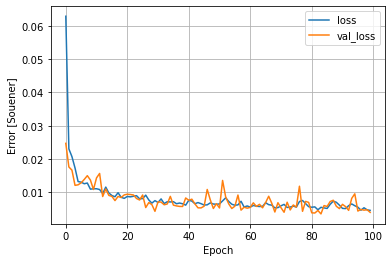

Total Absolute Error:  5.003836499718287*10^12
Mean Absolute Error:  6.08813298420524*10^8
Mean Percentage Error:  3.2274891043186322*10^1
Total Squared Error:  2.8076601821996308*10^22
Mean Squared Error:  3.416060569655227*10^18
Number of Points:  8.219*10^3
                TAE           TSE           MAE           MSE       MAPE  \
count  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   1.000000   
mean   5.003836e+12  2.807660e+22  6.088133e+08  3.416061e+18  32.274891   
std             NaN           NaN           NaN           NaN        NaN   
min    5.003836e+12  2.807660e+22  6.088133e+08  3.416061e+18  32.274891   
25%    5.003836e+12  2.807660e+22  6.088133e+08  3.416061e+18  32.274891   
50%    5.003836e+12  2.807660e+22  6.088133e+08  3.416061e+18  32.274891   
75%    5.003836e+12  2.807660e+22  6.088133e+08  3.416061e+18  32.274891   
max    5.003836e+12  2.807660e+22  6.088133e+08  3.416061e+18  32.274891   

         #Pts  
count     1.0  
mean   8219.0  
std   

Epoch 18/100
206/206 [==============================] - 2s 11ms/step - loss: 0.0077 - mae: 0.0051 - mse: 1.7514e-04 - log_mse: -9.4651 - log_mae: -5.3860 - exp_mse_mag: -3.7762 - exp_mae_mag: -2.2249 - exp_R2: 0.9859 - R2: 0.9884 - val_loss: 0.0054 - val_mae: 0.0036 - val_mse: 1.9369e-04 - val_log_mse: -10.0412 - val_log_mae: -5.7613 - val_exp_mse_mag: -4.1206 - val_exp_mae_mag: -2.4140 - val_exp_R2: 0.9695 - val_R2: 0.9716
Epoch 19/100
206/206 [==============================] - 2s 11ms/step - loss: 0.0087 - mae: 0.0066 - mse: 3.0006e-04 - log_mse: -9.0216 - log_mae: -5.2005 - exp_mse_mag: -3.5765 - exp_mae_mag: -2.1397 - exp_R2: 0.9712 - R2: 0.9768 - val_loss: 0.0082 - val_mae: 0.0062 - val_mse: 3.3554e-04 - val_log_mse: -8.8318 - val_log_mae: -5.1910 - val_exp_mse_mag: -3.5766 - val_exp_mae_mag: -2.1587 - val_exp_R2: 0.9551 - val_R2: 0.9587
Epoch 20/100
206/206 [==============================] - 2s 11ms/step - loss: 0.0071 - mae: 0.0050 - mse: 1.6544e-04 - log_mse: -9.5040 - log_mae:

In [ ]:
error_df = pd.DataFrame(columns=['TAE','TSE','MAE','MSE','MAPE','#Pts'])
   
normalized_species_train = halfData["normalized_species_train"]
Zmix_train = halfData["Zmix_train"] 
normalized_souener_train = halfData["normalized_souener_train"]
    
def train_model(model):
    global error_df
    history = model.fit([normalized_species_train,Zmix_train], 
                         normalized_souener_train,
                         validation_split=0.2,
                         verbose=1, 
                         epochs=100,
                         batch_size=32,
                         callbacks=[es])
    plot_loss(history)
    
    # data prep
    normalized_species_test = halfData["normalized_species_test"]
    Zmix_test =  halfData["Zmix_test"]
    
    normalized_souener_pred = model.predict([normalized_species_test,Zmix_test])
    
    # data prep
    scaler_souener = halfData["scaler_souener"]
    Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)
    Y_pred = Y_pred.flatten()
    Y_test = halfData["Y_test"]
    
    err = {k: v for k,v in zip(error_df.columns, computeAndPrintError(Y_pred, Y_test))}
    return err

for i in range(20):
    model = keras.models.load_model(f'base_code_model/base_code_model{i}.h5', custom_objects = custom_objects)
    err = train_model(model)
    error_df = error_df.append(err, ignore_index=True)
    print(error_df.describe())

In [ ]:
%%time

normalized_species_train = halfData["normalized_species_train"]
Zmix_train = halfData["Zmix_train"] 
normalized_souener_train = halfData["normalized_souener_train"]

history = model.fit([normalized_species_train,Zmix_train], 
                     normalized_souener_train,
                     validation_split=0.2,
                     verbose=1, 
                     epochs=100,
                     batch_size=32,
                     callbacks=[es])

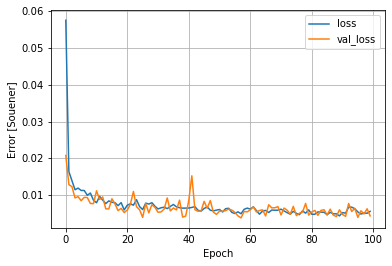

In [52]:
plot_loss(history)

In [60]:
normalized_species_test = halfData["normalized_species_test"]
Zmix_test =  halfData["Zmix_test"]

normalized_souener_pred = model.predict([normalized_species_test,Zmix_test])

In [54]:
scaler_souener = halfData["scaler_souener"]
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)
Y_pred = Y_pred.flatten()
Y_test = halfData["Y_test"]

err = computeAndPrintError(Y_pred, Y_test)
#error_df = error_df.append(err, ignore_index=True)
#error_df.describe()

In [ ]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

## RESULTS SUMMARY

<table>
<tr>
<td>Method </td>
<td>MAE</td>
</tr>
<tr>
<td>Framework </td>
<td>2.24 E+09</td>
</tr>
<tr>
<td>DNN (Non-Linear Embedding) </td>
<td>9.304 E+08</td>
</tr>    
<tr>
<td>DNN (Linear Embedding [No Constraints]) </td>
<td>2.042 E+09</td>
</tr>       
<tr>
<td>ChemTab (Unit Norm Constraints) </td>
<td>6.28 E+08</td>
</tr>
<tr>
<td>ChemTab (Orthogonal Weights Constraints) </td>
<td>6.05 E+08</td>
</tr>
<tr>
<td>ChemTab (Uncorrelated Features Constraints) </td>
<td>5.7 E+08</td>
</tr>
<tr>
<td>ChemTab (All Constraints) </td>
<td>8.008 E+08</td>
</tr>
    
</table>